# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.dates as mdates

%matplotlib inline

# Load the Preprocessed Train & Test Data

In [2]:
ticker = "AAPL"
train_df = pd.read_csv(f'{ticker}_processed_data_train.csv')
test_df = pd.read_csv(f'{ticker}_processed_data_test.csv')


## Ensure Date is datetime type

In [3]:
train_df['Date'] = pd.to_datetime(train_df['Date'])
test_df['Date'] = pd.to_datetime(test_df['Date'])

## Quick sanity check

In [4]:
print(train_df.columns)
print(test_df.columns)

Index(['Date', 'Close', 'High', 'Low', 'Open', 'Volume', 'Target'], dtype='object')
Index(['Date', 'Close', 'High', 'Low', 'Open', 'Volume', 'Target'], dtype='object')


# Moving Average Baseline Model

## Choose Moving Average Window Size

In [5]:
window_size = 5  # You can later try 10, 20, etc.

## Concatenate Last Part of Train + Test

In [6]:
# Take last 10 days from train
past_window = train_df[['Date', 'Close']].iloc[-window_size:]

# Combine
combined_test_df = pd.concat([past_window, test_df[['Date', 'Close']]], ignore_index=True)

## Make the Predictions

Use past data to predict future target. We shift after computing rolling mean.
shift(1): prediction for today must be bsaed only on yesterday and before

In [7]:
# 1. Rolling mean on Close price
combined_test_df['Prediction'] = combined_test_df['Close'].rolling(window=window_size).mean()

## Shift predictions by 1 day to predict next day's Close

In [8]:
combined_test_df['Prediction'] = combined_test_df['Prediction'].shift(1)

## Drop Missing Values

In [9]:
combined_test_df = combined_test_df.dropna(subset=['Prediction']).reset_index(drop=True)

# Extract Only Real Test Period

In [10]:
# 6. (Modified) Align Predictions back to Test Set
# Skip the first `window_size` rows from test_df to match prediction starting point
test_df = test_df.iloc[window_size:].reset_index(drop=True)

# Merge Predictions
test_df['Prediction'] = combined_test_df['Prediction']


# Evalulate Predictions

In [11]:
from sklearn.metrics import r2_score

mse = mean_squared_error(test_df['Target'], test_df['Prediction'])
rmse = np.sqrt(mse)  # (Modified)
mae = mean_absolute_error(test_df['Target'], test_df['Prediction'])
r2 = r2_score(test_df['Target'], test_df['Prediction'])  # Calculate R²

print(f'Moving Average Baseline (window={window_size}) Results:')
print(f'✅ RMSE: {rmse:.4f}')
print(f'✅ MAE: {mae:.4f}')
print(f'✅ R²: {r2:.4f}')


Moving Average Baseline (window=5) Results:
✅ RMSE: 8.0593
✅ MAE: 6.5822
✅ R²: 0.8863


# Visualize Results

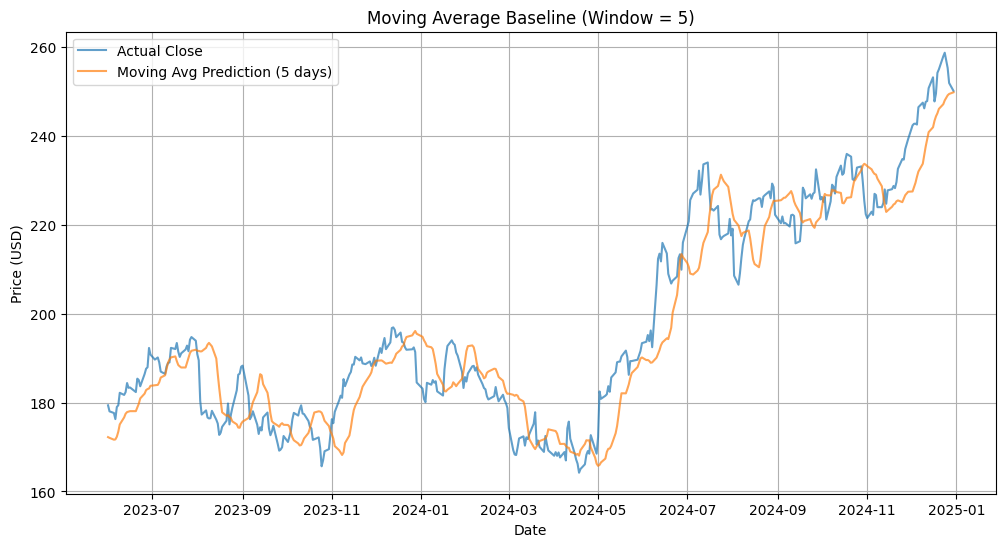

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(test_df['Date'], test_df['Target'], label='Actual Close', alpha=0.7)
plt.plot(test_df['Date'], test_df['Prediction'], label=f'Moving Avg Prediction ({window_size} days)', alpha=0.7)
plt.title(f'Moving Average Baseline (Window = {window_size})')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()
